### Imports & utils

In [1]:
%pip install datasets transformers[torch]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 21.2.3 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!wget https://raw.githubusercontent.com/akshaybhalotia/yc_company_scraper/main/data/yc_essential_data.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
from __future__ import annotations
import typing
from dataclasses import dataclass, field
import warnings
from contextlib import contextmanager
import itertools
import functools
import logging
from ast import literal_eval

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional
import transformers
import transformers.modeling_outputs
import datasets
import bp_mll

In [6]:
@contextmanager
def localize_globals(*exceptions: str, restore_values: bool = True):
    exceptions: typing.Set[str] = set(exceptions)

    old_globals: typing.Dict[str, typing.Any] = dict(globals())
    allowed: typing.Set[str] = set(old_globals.keys())
    allowed.update(exceptions)

    yield None

    new_globals: typing.Dict[str, typing.Any] = globals()

    for name in tuple(new_globals.keys()):
        if name not in allowed:
            del new_globals[name]

    if not restore_values:
        return

    new_globals.update(
        {k: v for k, v in old_globals.items() if k not in exceptions}
    )

In [7]:
logging.basicConfig(
    level=logging.INFO,
    format="[{levelname}] {message}",
    style="{",
)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Data preprocessing

In [9]:
data: pd.DataFrame = pd.read_csv("yc_essential_data.csv")

# Limit to the columns we're interested in
data = data[["name", "one_liner", "long_description", "tags"]]

# Convert tags to a list
data["tags"] = data["tags"].apply(literal_eval)
assert isinstance(data.at[0, "tags"], list), "Didn't work!"

# Okay, apparently an empty string makes a nan by default
# Gotta reverse it
data["one_liner"].replace(
    to_replace=np.nan,
    value="",
    inplace=True,
)

data["long_description"].replace(
    to_replace=np.nan,
    value="",
    inplace=True,
)

# Preview the results
data.head()

,name,one_liner,long_description,tags
0,Wufoo,Online form builder.,Wufoo is a web application that helps anybody ...,"[SaaS, Productivity]"
1,Project Wedding,,"Finding wedding vendors is hard. In 2007, a co...",[]
2,Clustrix,,Clustrix provides the leading scale-out relati...,[]
3,Inkling,,"Inkling, based in Chicago, Illinois, offers co...",[]
4,Audiobeta,,AudioBeta develops web-based applications that...,[]


In [10]:
data.sample(10)

,name,one_liner,long_description,tags
3926,Value Voting,Platform to defeat political extremism through...,Value Voting develops political targeting soft...,[Marketplace]
2063,Terapify,The leading mental healthcare platform in Lati...,Terapify offers high-quality on-demand mental ...,"[Mental Health Tech, Consumer Health Services,..."
4059,Rally,Rally is Zoom for social events,Rally is what Zoom breakouts should have been....,"[Collaboration, Video, Social]"
2608,Gas Pos,Modern Point of Sale for Gas Stations and Truc...,"We have taken an incredibly monopolized, overp...","[Fintech, SaaS, B2B]"
4043,Atmos,"The entire homebuilding process, all online",,"[Housing, Proptech]"
1894,HUBUC,Global Card Issuing and Payment Processing Engine,HUBUC P1 is a lightning-fast global card issui...,"[Fintech, Payments, B2B, API, Infrastructure]"
3722,Superpowered AI,API for Retrieval Augmented Generation,Superpowered AI makes it easy to build product...,"[Artificial Intelligence, Developer Tools, Gen..."
1518,Outschool,A live online learning platform that empowers ...,Outschool is an innovative education platform ...,"[Education, Marketplace]"
2781,Syncro,Zapier for scaling high-touch talent management,"Integrate your HRIS, ATS, and communication st...","[Workflow Automation, Recruiting]"
2155,Codeball,AI-Powered Code Review,"Codeball finds bugs in your Pull Requests, let...","[Artificial Intelligence, Developer Tools, SaaS]"


// TODO: Don't use the name, remove it from long_description as well?

In [214]:
# Gather all unique tags
with localize_globals("all_tags"):
    tags_set: set[str] = set(itertools.chain.from_iterable(data["tags"]))
    
    tags_list: list[str] = sorted(tags_set)
    # A special tag at index 0
    # tags_list.insert(0, "[DUMMY]")

    all_tags: pd.Series = pd.Series(tags_list)

all_tags

0          3D Printed Foods
1               3D Printing
2                        AI
3              AI Assistant
4      AI-Enhanced Learning
               ...         
324          Women's Health
325     Workflow Automation
326               eLearning
327                 eSports
328                    web3
Length: 329, dtype: object

### Pretrained models

In [55]:
tokenizer: transformers.DistilBertTokenizer = transformers.DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased",
    device=device,
)

# nlp_model: transformers.DistilBertModel = transformers.DistilBertModel.from_pretrained(
#     "distilbert-base-uncased",
# )

In [13]:
MAX_TOKENS: int = 512
EMBEDDING_SIZE: int = 768

### Dataset preparation

In [215]:
with localize_globals("complete_dataset"):
    def preprocess(batch: dict[str, typing.Any]) -> dict[str, typing.Any]:
        batch["orig_idx"] = torch.zeros(len(batch["name"]))
        for i, name in enumerate(batch["name"]):
            batch["orig_idx"][i] = data.index[data["name"] == name].values[0]
        
        for column in (
            "name",
            "one_liner",
            "long_description",
        ):
            tmp = tokenizer(
                batch[column],
                truncation=True,
                padding="max_length",
                max_length=MAX_TOKENS,
                return_tensors="pt",
                add_special_tokens=True,
            ).data

            # logging.info(f"!! {tmp['input_ids'].shape}, {tmp['attention_mask'].shape}")
            batch[column] = tmp["input_ids"].to(device)
            batch[f"{column}_mask"] = tmp["attention_mask"].to(device)
        
        # TODO: Since this is the target, process it separately?
        if "tags" in batch:
            batch["tags"] = torch.stack([
                torch.tensor(all_tags.apply(tags.__contains__), dtype=torch.float, device=device)
                for tags in batch["tags"]
            ])
            # batch["tags"][:, 0] = 1.  # Dummy tag is always present

        return batch

    complete_dataset = (
        datasets.Dataset
        .from_pandas(data)
        # .with_format(None)
        .with_transform(preprocess)
    )

complete_dataset

Dataset({
    features: ['name', 'one_liner', 'long_description', 'tags'],
    num_rows: 4423
})

In [216]:
with localize_globals("train_dataset", "val_dataset", "test_dataset"):
    train_test_split = complete_dataset.train_test_split(test_size=0.2)
    train_dataset = train_test_split["train"]

    test_val_split = train_test_split["test"].train_test_split(test_size=0.3)
    val_dataset = test_val_split["train"]
    test_dataset = test_val_split["test"]

train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['name', 'one_liner', 'long_description', 'tags'],
     num_rows: 3538
 }),
 Dataset({
     features: ['name', 'one_liner', 'long_description', 'tags'],
     num_rows: 619
 }),
 Dataset({
     features: ['name', 'one_liner', 'long_description', 'tags'],
     num_rows: 266
 }))

### Model definition

In [217]:
class NLPWrapperModule(nn.Module):
    """
    Wraps an nlp module and performs the following pre- and postprocessing:
    
    - Takes a dictionary and `**`-unwraps it for the submodule's input
    - Takes `.last_hidden_state` from the submodule's result and returns only it
    
    Note that the wrapper is opaque, hiding the parameters of the underlying
    NLP module to avoid tuning and saving it.
    """
    
    bert: nn.Module
    
    def __init__(self) -> None:
        super().__init__()
        
        bert: transformers.DistilBertModel = transformers.DistilBertModel.from_pretrained(
            "distilbert-base-uncased",
        )
        
        bert.to(device)
        
        # I can't afford to also tune BERT, nor do I need to
        bert.train(False)
        for param in bert.parameters():
            param.requires_grad = False
        
        # I want it to exclude bert from the perceived parameters
        object.__setattr__(self, "bert", bert)
        
        assert not self._modules, f"Opacity failure: {self._modules}"
    
    def forward(
        self,
        params: typing.Mapping[str, torch.Tensor],
    ) -> torch.Tensor:
        # (batch_size, MAX_TOKENS, EMBEDDING_SIZE)
        result: torch.Tensor = self.bert(**params).last_hidden_state
        
        # The [CLS] token is added at position 0 along axis 1
        return result[:, 0, :]
        
        # Sum the result along axis 1 with weights equal to the attention mask
        # (batch_size, EMBEDDING_SIZE)
        # return torch.sum(result * params["attention_mask"].unsqueeze(-1), dim=1)
    
    # A hack, but it works
    def to(self, device: torch.device) -> None:
        super().to(device)
        self.bert.to(device)


In [218]:
class MultiNLPModule(nn.Module):
    """
    Takes multiple inputs from named columns of a dataset,
    passes them to BERT, and concatenates the results.
    """
    
    inputs: list[str]
    submodule: NLPWrapperModule
    
    def __init__(
        self,
        inputs: typing.Collection[str],
    ) -> None:
        super().__init__()
        
        self.inputs = list(inputs)
        self.submodule = NLPWrapperModule()
    
    def forward(
        self,
        input_dict: typing.Mapping[str, torch.Tensor],
    ) -> torch.Tensor:
        assert set(input_dict.keys()).issuperset(self.inputs), \
            f"Missing parameters: expected {set(self.inputs)}, got only {set(input_dict.keys())}"

        return torch.cat([
            self.submodule(input_dict[name])
            for name in self.inputs
        ], dim=-1)

In [219]:
with localize_globals():
    import importlib
    importlib.reload(bp_mll)

In [220]:
with localize_globals():
    tags = torch.tensor([[1.0, 1.0, 0.0]]).to(device)
    logits = torch.tensor([[0.8, 0.5, 0.0]]).to(device)
    # logits = torch.tensor([[1.0, 0.0, 0.0]]).to(device)
    
    print(logits, tags)
    
    print("BP-MLL", bp_mll.BPMLLLoss().to(device)(logits, tags))
    print("Binary cross entropy", nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0])).to(device)(logits, tags))

tensor([[0.8000, 0.5000, 0.0000]], device='cuda:0') tensor([[1., 1., 0.]], device='cuda:0')
BP-MLL tensor(0.5279, device='cuda:0')
Binary cross entropy tensor(0.3054, device='cuda:0')


In [243]:
with localize_globals("positive_weight_imbalance"):
    positives: float = 0
    total: float = 0
    for batch in train_dataset.iter(1024):
        positives += batch["tags"].sum()
        total += batch["tags"].nelement()
    
    positive_weight_imbalance = total / positives
    print(f"Positive weight imbalance: {positive_weight_imbalance}")

Positive weight imbalance: 132.4535675048828


In [264]:
class YCTagPredictorConfig(transformers.modeling_utils.PretrainedConfig):
    model_type: typing.ClassVar[str] = "yc_tag_predictor"

    def __init__(self, **kwargs: typing.Any) -> None:
        super().__init__(**kwargs)


class YCTagPredictorModel(transformers.modeling_utils.PreTrainedModel):
    config_class = YCTagPredictorConfig
    
    model: nn.Module
    criterion: nn.Module

    def __init__(self, config: YCTagPredictorConfig) -> None:
        super().__init__(config)

        self.model = nn.Sequential(
            MultiNLPModule(inputs=(
                # "name",
                "one_liner",
                "long_description",
            )),
            nn.Linear(
                # in_features=EMBEDDING_SIZE * 3,
                in_features=EMBEDDING_SIZE * 2,
                out_features=len(all_tags),
            ),
            # nn.Sigmoid(),
        ).to(device)
        
        # https://en.wikipedia.org/wiki/Multi-label_classification?useskin=vector#:~:text=neural%20networks%3A%20BP%2DMLL%20is%20an%20adaptation%20of%20the%20popular%20back%2Dpropagation%20algorithm%20for%20multi%2Dlabel%20learning.
        # https://github.com/idocx/BP_MLL_Pytorch
        # self.criterion = bp_mll.BPMLLLoss()
        # self.criterion = nn.BCEWithLogitsLoss().to(device)
        # self.criterion = nn.MSELoss().to(device)
        # self.criterion = nn.L1Loss().to(device)
        self.criterion = nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor([positive_weight_imbalance]),
        ).to(device)

    def forward(
        self,
        *,
        name: torch.Tensor,
        name_mask: torch.Tensor,
        one_liner: torch.Tensor,
        one_liner_mask: torch.Tensor,
        long_description: torch.Tensor,
        long_description_mask: torch.Tensor,
        tags: torch.Tensor | None = None,
        batch: bool = True,
        confidence_threshold: float | None = None,
        **kwargs,
    ) -> dict[str, typing.Any]:
        if not batch:
            name = name.unsqueeze(0)
            name_mask = name_mask.unsqueeze(0)
            one_liner = one_liner.unsqueeze(0)
            one_liner_mask = one_liner_mask.unsqueeze(0)
            long_description = long_description.unsqueeze(0)
            long_description_mask = long_description_mask.unsqueeze(0)
            
            if tags is not None:
                tags = tags.unsqueeze(0)
        
        result: dict[str, torch.Tensor] = {}
        
        logits: torch.Tensor = self.model(dict(
            # name=dict(
            #     input_ids=name,
            #     attention_mask=name_mask,
            # ),
            one_liner=dict(
                input_ids=one_liner,
                attention_mask=one_liner_mask,
            ),
            long_description=dict(
                input_ids=long_description,
                attention_mask=long_description_mask,
            ),
        ))
        
        result["logits"] = logits
        if not batch:
            result["logits"] = result["logits"].squeeze(0)

        if tags is not None:
            loss: torch.Tensor = self.criterion(logits, tags)
            
            if loss.isnan().sum() > 0:
                raise ValueError("NaN in loss")
            
            result["loss"] = loss
            if not batch:
                result["loss"] = result["loss"].squeeze(0)
            
            del loss
        
        if confidence_threshold is not None:
            predictions = nn.functional.sigmoid(logits)
            
            predicted_tags = [
                []
                for _ in range(predictions.shape[0])
            ]
            
            for batch_idx, tag_idx in (predictions >= confidence_threshold).nonzero():
                predicted_tags[batch_idx].append(tag_idx)
            
            if not batch:
                predicted_tags = predicted_tags[0]
            
            result["predicted_tags"] = predicted_tags
            
            del predicted_tags
        
        return result
    
    def ensure_device(self) -> None:
        """
        Our trick with the NLPModule opacity doesn't always seem to work, so this forces it
        """
        
        self.model[0].submodule.to(self.device)

In [265]:
model = YCTagPredictorModel(
    YCTagPredictorConfig(),
)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at C:\Users\Abel/.cache\huggingface\transformers\23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.11.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\Abel/.cache\huggingface\transformers\9c169103d7e5a73936dd2b627e42851bec0831212b6

In [ ]:
model = YCTagPredictorModel.from_pretrained("./trained_model")

In [266]:
with localize_globals():
    # model.to(device)
    # model.ensure_device()
    
    actual_shape = model(**next(train_dataset.iter(1)))["logits"][0].shape
    target_shape = next(iter(train_dataset))["tags"].shape

    logging.info(f"{actual_shape=}, {target_shape=}")

    assert actual_shape == target_shape, "Bad model result shape"


[INFO] actual_shape=torch.Size([329]), target_shape=torch.Size([329])


### Model training

(Note: may be skipped if you already have a trained model)

In [267]:
training_args = transformers.TrainingArguments(
    output_dir="./training_output",
    logging_dir="./training_logs",
    label_names=["tags"],
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    remove_unused_columns=False,
    num_train_epochs=5,
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    do_train=True,
    do_eval=True,
    dataloader_pin_memory=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [268]:
def compute_metrics(
    eval_pred: transformers.trainer_utils.EvalPrediction,
) -> dict[str, float]:
    logits, labels = map(lambda x: torch.tensor(x, device=device), eval_pred)
    predictions = (nn.functional.sigmoid(logits) >= 0.75).float()
    
    result: dict[str, torch.Tensor] = {}
    
    result["accuracy"] = (predictions == labels).float().mean().item()
    result["precision"] = (predictions * labels).sum().float() / predictions.sum().float()
    result["recall"] = (predictions * labels).sum().float() / labels.sum().float()
    
    # print(f"!\n{logits=}\n{labels=}\n{predictions=}\n")
    
    # TODO: More?
    
    return result


In [269]:
trainer: transformers.Trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [302]:
trainer.train(resume_from_checkpoint=True)

Loading model from ./training_output\checkpoint-886).
***** Running training *****
  Num examples = 3538
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2215
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 2
  Continuing training from global step 886
  Will skip the first 2 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

  0%|          | 0/2215 [00:00<?, ?it/s]

c:\Program Files\Python310\lib\site-packages\transformers\modeling_utils.py:383: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  warnings.warn(


{'loss': 0.8731, 'learning_rate': 2.9683972911963887e-05, 'epoch': 2.03}
{'loss': 0.8536, 'learning_rate': 2.742663656884876e-05, 'epoch': 2.26}
{'loss': 0.8046, 'learning_rate': 2.5169300225733633e-05, 'epoch': 2.48}
{'loss': 0.8543, 'learning_rate': 2.291196388261851e-05, 'epoch': 2.71}
{'loss': 0.8707, 'learning_rate': 2.0654627539503386e-05, 'epoch': 2.93}


***** Running Evaluation *****
  Num examples = 619
  Batch size = 8


  0%|          | 0/78 [00:00<?, ?it/s]

Saving model checkpoint to ./training_output\checkpoint-1329
Configuration saved in ./training_output\checkpoint-1329\config.json
Model weights saved in ./training_output\checkpoint-1329\pytorch_model.bin


{'eval_loss': 0.850267231464386, 'eval_accuracy': 0.947650671005249, 'eval_precision': 0.07658116519451141, 'eval_recall': 0.5455145239830017, 'eval_runtime': 21.3889, 'eval_samples_per_second': 28.94, 'eval_steps_per_second': 3.647, 'epoch': 3.0}


c:\Program Files\Python310\lib\site-packages\transformers\modeling_utils.py:383: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  warnings.warn(


{'loss': 0.8144, 'learning_rate': 1.8397291196388265e-05, 'epoch': 3.16}
{'loss': 0.8281, 'learning_rate': 1.613995485327314e-05, 'epoch': 3.39}
{'loss': 0.841, 'learning_rate': 1.3882618510158013e-05, 'epoch': 3.61}
{'loss': 0.8282, 'learning_rate': 1.1625282167042891e-05, 'epoch': 3.84}


***** Running Evaluation *****
  Num examples = 619
  Batch size = 8


  0%|          | 0/78 [00:00<?, ?it/s]

Saving model checkpoint to ./training_output\checkpoint-1772
Configuration saved in ./training_output\checkpoint-1772\config.json
Model weights saved in ./training_output\checkpoint-1772\pytorch_model.bin


{'eval_loss': 0.8437275290489197, 'eval_accuracy': 0.9488193392753601, 'eval_precision': 0.07934258878231049, 'eval_recall': 0.5540897250175476, 'eval_runtime': 35.1112, 'eval_samples_per_second': 17.63, 'eval_steps_per_second': 2.222, 'epoch': 4.0}


c:\Program Files\Python310\lib\site-packages\transformers\modeling_utils.py:383: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  warnings.warn(


{'loss': 0.8193, 'learning_rate': 9.367945823927766e-06, 'epoch': 4.06}
{'loss': 0.8143, 'learning_rate': 7.1106094808126415e-06, 'epoch': 4.29}
{'loss': 0.8309, 'learning_rate': 4.853273137697517e-06, 'epoch': 4.51}
{'loss': 0.8378, 'learning_rate': 2.5959367945823926e-06, 'epoch': 4.74}
{'loss': 0.812, 'learning_rate': 3.386004514672686e-07, 'epoch': 4.97}


***** Running Evaluation *****
  Num examples = 619
  Batch size = 8


  0%|          | 0/78 [00:00<?, ?it/s]

Saving model checkpoint to ./training_output\checkpoint-2215
Configuration saved in ./training_output\checkpoint-2215\config.json
Model weights saved in ./training_output\checkpoint-2215\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 0.8419126272201538, 'eval_accuracy': 0.9494724273681641, 'eval_precision': 0.08035201579332352, 'eval_recall': 0.5540897250175476, 'eval_runtime': 41.896, 'eval_samples_per_second': 14.775, 'eval_steps_per_second': 1.862, 'epoch': 5.0}
{'train_runtime': 584.3984, 'train_samples_per_second': 30.27, 'train_steps_per_second': 3.79, 'train_loss': 0.49874645345098007, 'epoch': 5.0}


TrainOutput(global_step=2215, training_loss=0.49874645345098007, metrics={'train_runtime': 584.3984, 'train_samples_per_second': 30.27, 'train_steps_per_second': 3.79, 'train_loss': 0.49874645345098007, 'epoch': 5.0})

In [303]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 619
  Batch size = 8


  0%|          | 0/78 [00:00<?, ?it/s]

{'eval_loss': 0.8419126272201538,
 'eval_accuracy': 0.9494724273681641,
 'eval_precision': 0.08035201579332352,
 'eval_recall': 0.5540897250175476,
 'eval_runtime': 47.1096,
 'eval_samples_per_second': 13.14,
 'eval_steps_per_second': 1.656,
 'epoch': 5.0}

In [304]:
# Note: it might not save properly, in fact.
model.save_pretrained("trained_model")

Configuration saved in trained_model\config.json
Model weights saved in trained_model\pytorch_model.bin


### Inference

(Note: may be skipped if you already have data_with_predictions)

In [305]:
with localize_globals():
    for batch in itertools.islice(train_dataset, 5):
        result: dict[str, typing.Any] = model(**batch, batch=False, confidence_threshold=0.75)
        
        # print(result)
        
        pred_tags_idxs: list[int] = [
            i.item() for i in result["predicted_tags"]
        ]
        true_tags_idxs: list[int] = (batch["tags"] == 1).nonzero()[:, 0].tolist()
        
        # print(true_tags_idxs)
        # print(pred_tags_idxs)
        # print(result["logits"][batch["tags"] == 1])
        
        pred_tags: pd.Series = all_tags[pred_tags_idxs]
        actual_tags: pd.Series = all_tags[true_tags_idxs]
        
        name: str = data.at[batch["orig_idx"].item(), "name"]
        
        print(f"Company: {name}")
        print(f"Predicted:\n{pred_tags}")
        print(f"Actual:\n{actual_tags}")
        print(f"Loss: {result['loss']}")
        print()
        
        # break

Company: Fobo
Predicted:
2                           AI
19                   Analytics
23     Artificial Intelligence
31                         B2B
60                     Climate
73                    Consumer
111            Developer Tools
121                 E-commerce
124                  Education
141                    Fintech
155              Generative AI
201           Machine Learning
206                Marketplace
237                   Payments
273                       SaaS
dtype: object
Actual:
120        E-Commerce
198    Location-based
dtype: object
Loss: 1.5809268951416016

Company: Skysheet
Predicted:
2                           AI
7                          API
19                   Analytics
23     Artificial Intelligence
31                         B2B
60                     Climate
73                    Consumer
83               Crypto / Web3
111            Developer Tools
121                 E-commerce
124                  Education
132                 Enterprise
141

In [306]:
data_with_predictions = data.assign(
    predicted_tags=[[] for _ in range(len(data))],
)

data_with_predictions


,name,one_liner,long_description,tags,predicted_tags
0,Wufoo,Online form builder.,Wufoo is a web application that helps anybody ...,"[SaaS, Productivity]",[]
1,Project Wedding,,"Finding wedding vendors is hard. In 2007, a co...",[],[]
2,Clustrix,,Clustrix provides the leading scale-out relati...,[],[]
3,Inkling,,"Inkling, based in Chicago, Illinois, offers co...",[],[]
4,Audiobeta,,AudioBeta develops web-based applications that...,[],[]
...,...,...,...,...,...
4418,Assembled,"Pivoted to TenXList, a professional network of...",,"[Education, Recruiting]",[]
4419,TellFi,Google Voice for business.,"Fastest, easiest way to setup a phone system f...","[Messaging, Enterprise]",[]
4420,Beetailer,Facebook stores.,Beetailer. Your online store in Facebook\r\n\r...,"[E-Commerce, Retail]",[]
4421,Inporia,Fashion shopping email list.,Inporia's current product is Kaleidoscope - a ...,"[E-Commerce, Retail, Fashion]",[]


In [307]:
with localize_globals("data_with_predictions"):
    for row in tqdm.tqdm(complete_dataset):
        i = row["orig_idx"].item()
        
        result = model(**row, batch=False, confidence_threshold=0.75)
        predicted_tags: list[int] = [
            i.item() for i in result["predicted_tags"]
        ]
        
        data_with_predictions.at[i, "predicted_tags"] = predicted_tags


100%|██████████| 4423/4423 [02:13<00:00, 33.06it/s]


In [308]:
data_with_predictions["predicted_tags"] = data_with_predictions["predicted_tags"].apply(
    lambda x: list(all_tags[x])
)

In [309]:
data_with_predictions.at[0, "tags"]

['SaaS', 'Productivity']

In [310]:

data_with_predictions.at[0, "predicted_tags"]

['AI',
 'API',
 'Analytics',
 'Artificial Intelligence',
 'B2B',
 'Consumer',
 'Developer Tools',
 'E-commerce',
 'Education',
 'Fintech',
 'Generative AI',
 'Machine Learning',
 'Marketplace',
 'Open Source',
 'Payments',
 'Productivity',
 'SaaS']

In [311]:
data_with_predictions.to_csv("data_with_predictions.csv")

In [312]:
data_with_predictions = pd.read_csv("data_with_predictions.csv", index_col=0)

data_with_predictions["tags"] = data_with_predictions["tags"].apply(literal_eval)
data_with_predictions["predicted_tags"] = data_with_predictions["predicted_tags"].apply(literal_eval)

data_with_predictions["one_liner"].replace(
    to_replace=np.nan,
    value="",
    inplace=True,
)

data_with_predictions["long_description"].replace(
    to_replace=np.nan,
    value="",
    inplace=True,
)

data_with_predictions


,name,one_liner,long_description,tags,predicted_tags
0,Wufoo,Online form builder.,Wufoo is a web application that helps anybody ...,"[SaaS, Productivity]","[AI, API, Analytics, Artificial Intelligence, ..."
1,Project Wedding,,"Finding wedding vendors is hard. In 2007, a co...",[],"[AI, Artificial Intelligence, B2B, Consumer, D..."
2,Clustrix,,Clustrix provides the leading scale-out relati...,[],"[AI, API, Analytics, Artificial Intelligence, ..."
3,Inkling,,"Inkling, based in Chicago, Illinois, offers co...",[],"[AI, API, Analytics, Artificial Intelligence, ..."
4,Audiobeta,,AudioBeta develops web-based applications that...,[],"[AI, Artificial Intelligence, B2B, Consumer, D..."
...,...,...,...,...,...
4418,Assembled,"Pivoted to TenXList, a professional network of...",,"[Education, Recruiting]","[AI, Artificial Intelligence, B2B, Consumer, D..."
4419,TellFi,Google Voice for business.,"Fastest, easiest way to setup a phone system f...","[Messaging, Enterprise]","[AI, Analytics, Artificial Intelligence, B2B, ..."
4420,Beetailer,Facebook stores.,Beetailer. Your online store in Facebook\r\n\r...,"[E-Commerce, Retail]","[AI, Analytics, Artificial Intelligence, B2B, ..."
4421,Inporia,Fashion shopping email list.,Inporia's current product is Kaleidoscope - a ...,"[E-Commerce, Retail, Fashion]","[AI, Analytics, Artificial Intelligence, B2B, ..."


### Analysis

In [313]:
from collections import Counter

In [314]:
real_tag_frequencies = Counter(data["tags"].sum())
pred_tag_frequencies = Counter(data_with_predictions["predicted_tags"].sum())

In [315]:
real_tag_frequencies.most_common(20)

[('SaaS', 968),
 ('B2B', 824),
 ('Fintech', 657),
 ('Developer Tools', 403),
 ('Artificial Intelligence', 372),
 ('Marketplace', 317),
 ('AI', 214),
 ('Machine Learning', 209),
 ('E-commerce', 175),
 ('Education', 166),
 ('Analytics', 157),
 ('Generative AI', 156),
 ('Climate', 147),
 ('Consumer', 142),
 ('Healthcare', 134),
 ('Open Source', 132),
 ('Payments', 130),
 ('API', 128),
 ('Health Tech', 125),
 ('Productivity', 114)]

In [316]:
pred_tag_frequencies.most_common(20)

[('Artificial Intelligence', 4369),
 ('B2B', 4369),
 ('Fintech', 4369),
 ('Marketplace', 4369),
 ('SaaS', 4369),
 ('Developer Tools', 4313),
 ('AI', 4305),
 ('Machine Learning', 4260),
 ('E-commerce', 4192),
 ('Education', 4121),
 ('Consumer', 3880),
 ('Generative AI', 3659),
 ('Payments', 3655),
 ('Analytics', 3539),
 ('Climate', 3177),
 ('API', 2257),
 ('Healthcare', 2112),
 ('Enterprise', 1436),
 ('Productivity', 1359),
 ('Health Tech', 1218)]

Apparently, the cutoff of 80% certainty has been too low 

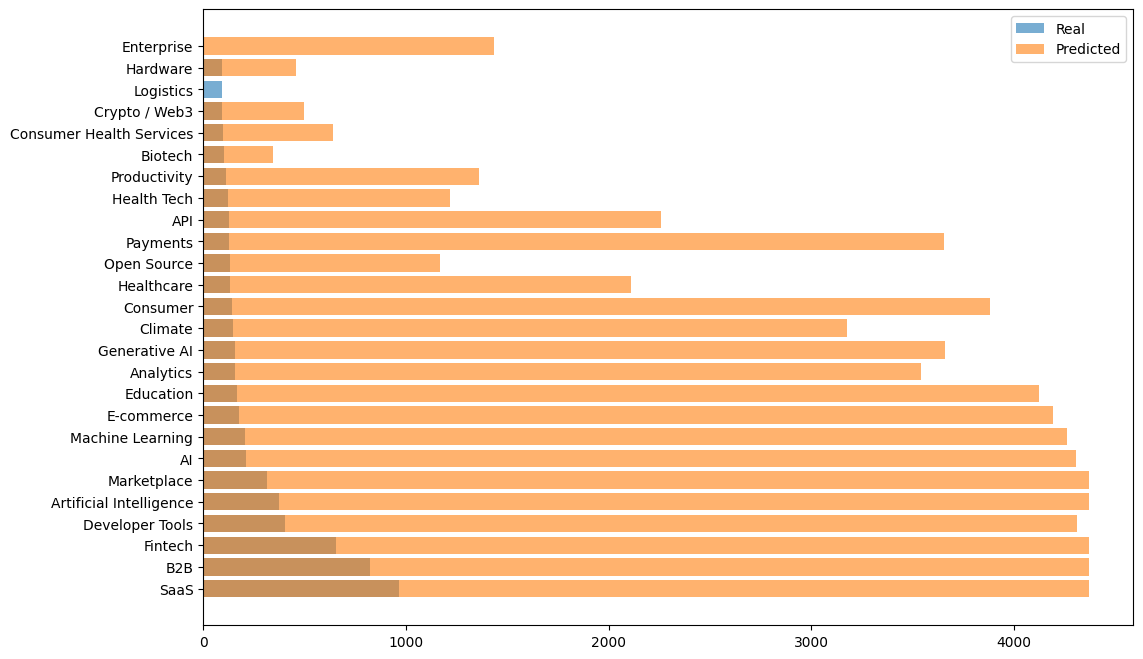

In [317]:
with localize_globals():
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for label, counter in (
        ("Real", real_tag_frequencies),
        ("Predicted", pred_tag_frequencies),
    ):
        n: typing.Final[int] = 25
        
        top_n: list[tuple[str, int]] = counter.most_common(n)
        
        x, y = zip(*top_n)
        
        ax.barh(x, y, label=label, alpha=0.6)
    
    ax.legend()


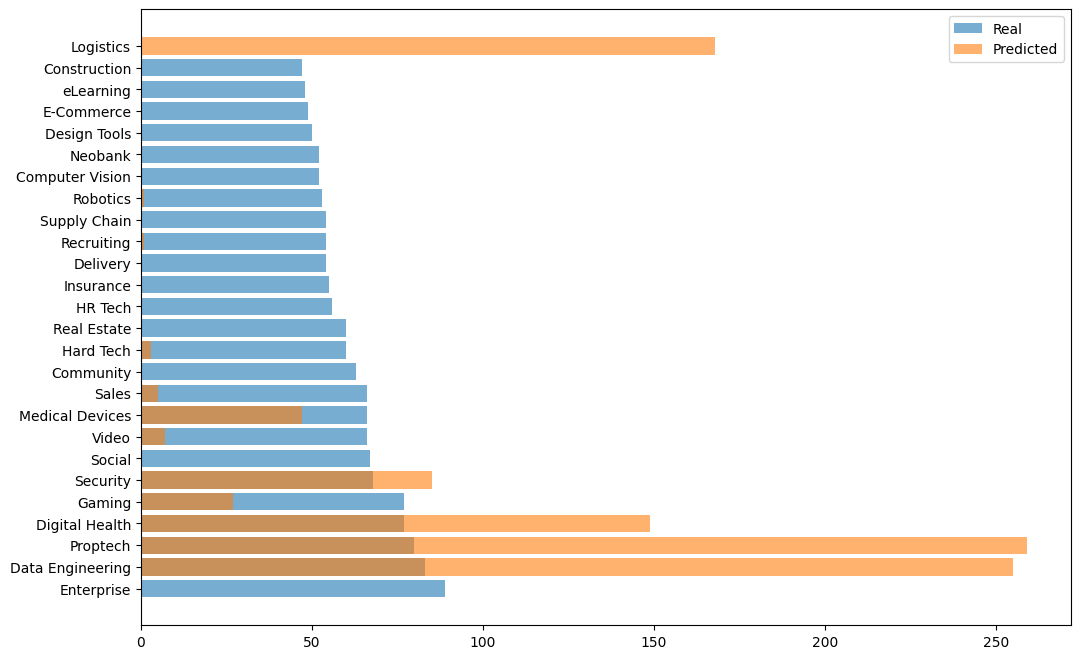

In [318]:
with localize_globals():
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for label, counter in (
        ("Real", real_tag_frequencies),
        ("Predicted", pred_tag_frequencies),
    ):
        top_n: list[tuple[str, int]] = list(itertools.islice(counter.most_common(100), 25, 50))
        
        x, y = zip(*top_n)
        
        ax.barh(x, y, label=label, alpha=0.6)
    
    ax.legend()

// TODO: Sort tags by delta frequency (the magnitude of error)

In [321]:
with localize_globals("delta_counter"):
    delta_counter = Counter(data["tags"].sum())

    for tag in data_with_predictions["predicted_tags"].sum():
        delta_counter[tag] -= 1

    for tag in delta_counter:
        delta_counter[tag] = -abs(delta_counter[tag]) / real_tag_frequencies[tag]

delta_counter.most_common(20)


[('Security', -0.25),
 ('Medical Devices', -0.2878787878787879),
 ('Gaming', -0.6493506493506493),
 ('Logistics', -0.7872340425531915),
 ('Video', -0.8939393939393939),
 ('Sales', -0.9242424242424242),
 ('Digital Health', -0.935064935064935),
 ('Hard Tech', -0.95),
 ('Robotics', -0.9811320754716981),
 ('Recruiting', -0.9814814814814815),
 ('Media', -1.0),
 ('ML', -1.0),
 ('Email', -1.0),
 ('Social', -1.0),
 ('E-Commerce', -1.0),
 ('Music', -1.0),
 ('LegalTech', -1.0),
 ('eLearning', -1.0),
 ('DevSecOps', -1.0),
 ('Next-gen Network Security', -1.0)]

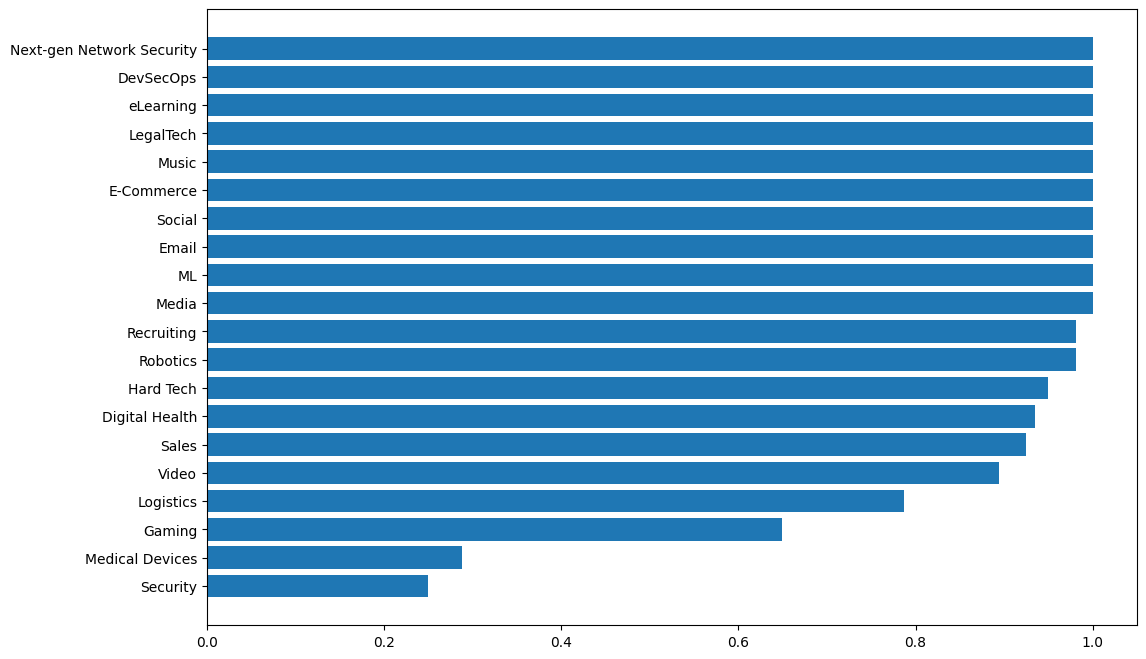

In [325]:
with localize_globals():
    fig, ax = plt.subplots(figsize=(12, 8))

    top_n: list[tuple[str, int]] = delta_counter.most_common(20)
    
    x, y = zip(*top_n)
    
    ax.barh(x, -np.array(y))